In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import itertools
%matplotlib inline
# import wrf

# plot styles/formatting
from matplotlib import cm
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature


# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
d = {'baja': {'ext': [-115., -110., 27., 32.],
              'start_pt': [33.0, -118.],
              'end_pt': [29.0, -109.]},
     
     'san_juan': {'ext': [-109., -105., 37., 39.],
              'start_pt': [38.0, -112.],
              'end_pt': [38.0, -102.]},

     'gulf_of_mexico': {'ext': [-99., -93., 25., 31.],
              'start_pt': [28.0, -100.],
              'end_pt': [31.0, -93.]}
    }
             

In [4]:
## iterate through options
region = 'gulf_of_mexico' ## 'san_juan' 'baja' 'gulf_of_mexico'
varname_lst = ['700z', 'ivt']
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON', 'NDJFMA', 'MJJASO']
ext = [-140., -90., 20, 50]

tmp_lst = []
tmp_lst2 = []
for i, varname in enumerate(varname_lst):  
    ds_lst = []
    ds_lst2 = []
    for j, ssn in enumerate(ssn_lst):
        ## load non-anomaly composite data
        path = '/home/dnash/DATA/preprocessed/ERA5_composites/'
        fname1 = path + '{0}/{2}/filtered_anomaly_composite_{0}_{1}.nc'.format(varname, ssn, region)
        fname2 = path + '{0}/{2}/filtered_anomaly_composite_tvals_{0}_{1}.nc'.format(varname, ssn, region)
    
        ds = xr.open_dataset(fname1)
        ds = ds.sel(latitude=slice(ext[3], ext[2]), longitude=slice(ext[0], ext[1]))
        ds_lst.append(ds)

        ds2 = xr.open_dataset(fname2)
        ds2 = ds2.sel(latitude=slice(ext[3], ext[2]), longitude=slice(ext[0], ext[1]))
        ds_lst2.append(ds2)

    ## concat ds_lst along ssn
    tmp = xr.concat(ds_lst, pd.Index(ssn_lst, name="ssn"))
    tmp_lst.append(tmp)

    tmp2 = xr.concat(ds_lst2, pd.Index(ssn_lst, name="ssn"))
    tmp_lst2.append(tmp2)

## merge two datasets
ds4 = xr.merge(tmp_lst)
ds4

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, ssn: 6)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -90.5 -90.25 -90.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * ssn        (ssn) object 'DJF' 'MAM' 'JJA' 'SON' 'NDJFMA' 'MJJASO'
Data variables:
    z          (ssn, latitude, longitude) float64 -338.5 -288.5 ... -3.372
    ivtv       (ssn, latitude, longitude) float64 585.9 585.5 ... 4.791 3.562
    ivtu       (ssn, latitude, longitude) float64 205.9 207.3 ... -31.72 -32.09
    ivt        (ssn, latitude, longitude) float64 538.4 538.8 ... 17.26 18.32

In [5]:
## merge tvalue anomaly datasets
ds3 = xr.merge(tmp_lst2)
ds3

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, ssn: 6)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -90.5 -90.25 -90.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * ssn        (ssn) object 'DJF' 'MAM' 'JJA' 'SON' 'NDJFMA' 'MJJASO'
Data variables:
    z          (ssn, latitude, longitude) bool False False False ... False False
    ivtv       (ssn, latitude, longitude) bool False False False ... False False
    ivtu       (ssn, latitude, longitude) bool False False False ... True True
    ivt        (ssn, latitude, longitude) bool False False False ... True True

In [6]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = ds.latitude.values
lons = ds.longitude.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

-185.35048449291992 547.2731270747878
-8.140102194866618 10.436662410325685
-63.759130976819435 45.854499966276975
-3.7456301363064775 5.070772301064535
-33.62406601074818 79.04600904973965
-2.184911026618144 1.8797625219742844
-53.84270425698483 149.11785968517356
-6.123728917258356 6.23458724817648


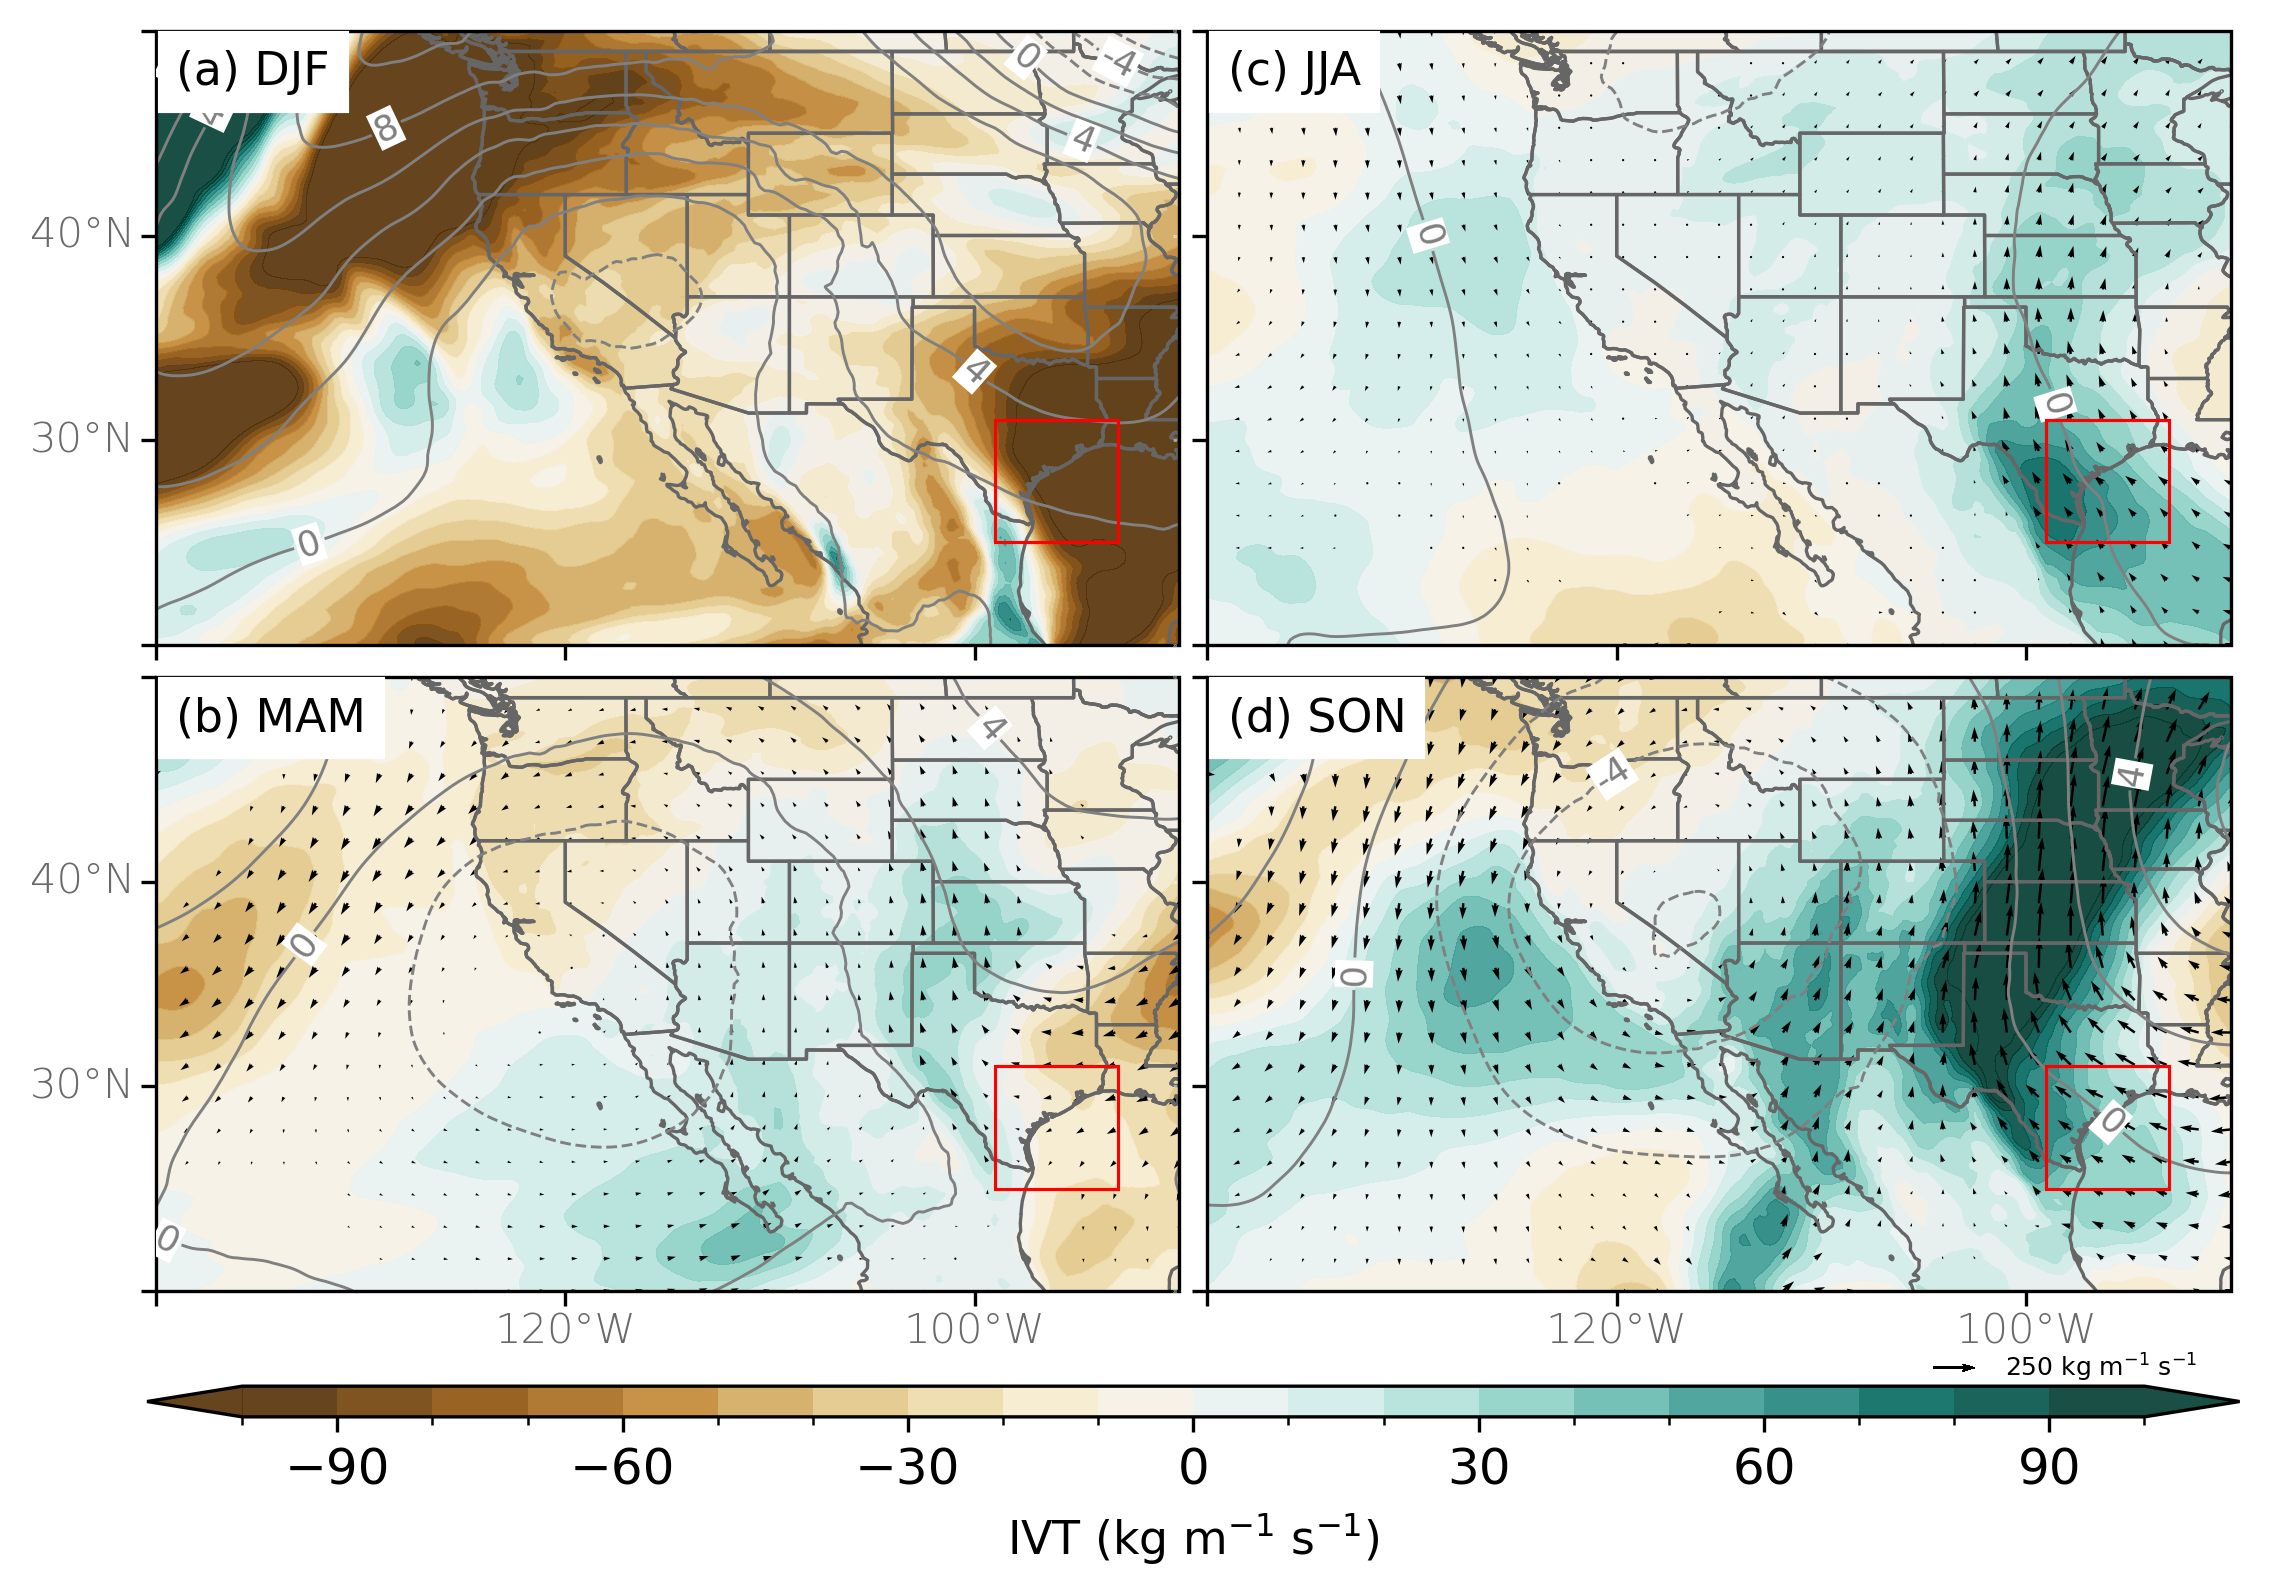

In [7]:
# Create figure
fig = plt.figure(figsize=(9, 6))
fig.dpi = 300
fname = path_to_figs + '{0}_IVT_700z_anom-composite_ssn'.format(region)
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 4
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

#################
### COMPOSITE ###
#################

rowidx = [0, 1, 0, 1]
colidx = [0, 0, 1, 1]
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']
llats = [True, True, False, False]
blons = [False, True, False, True]
for i, ssn in enumerate(ssn_lst):
    ds = ds4.sel(ssn=ssn)
    tval = ds3.sel(ssn=ssn)
    ax = fig.add_subplot(gs[rowidx[i], colidx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats[i], right_lats=False, bottom_lons=blons[i])
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    # Contour Filled
    lats = ds.latitude.values
    lons = ds.longitude.values
    ivt = ds.ivt.values
    print(ivt.min(), ivt.max())
    cmap = cm.BrBG
    bnds = np.arange(-100., 110., 10)
    cbarticks = bnds[::2]
    norm = mcolors.BoundaryNorm(bnds, cmap.N)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='both')

    # Wind barbs / vectors 
    uvec_mask = ds.ivtu.where((tval.ivtu == True) | (tval.ivtv == True)).values
    vvec_mask = ds.ivtv.where((tval.ivtu == True) | (tval.ivtv == True)).values

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = ds.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    clevs = np.arange(-20, 22, 2)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
    cl = ax.clabel(cs, clevs[::2], **kw_clabels)
    for txt in cl:
                txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))



    ext3 = d[region]['ext']
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='r',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))

    titlestring = '({0}) {1}'.format(letter_lst[i], ssn)
    ax.text(0.02, 0.97, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)


# quiver key
qk = ax.quiverkey(Q, 0.75, -0.125, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})
# Colorbar (single)
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

-113.81455946512742 54.33051699313277
-5.687218510893361 6.051249878018617
-28.31633940732571 71.22976124560851
-2.63841162926333 2.923553717107853


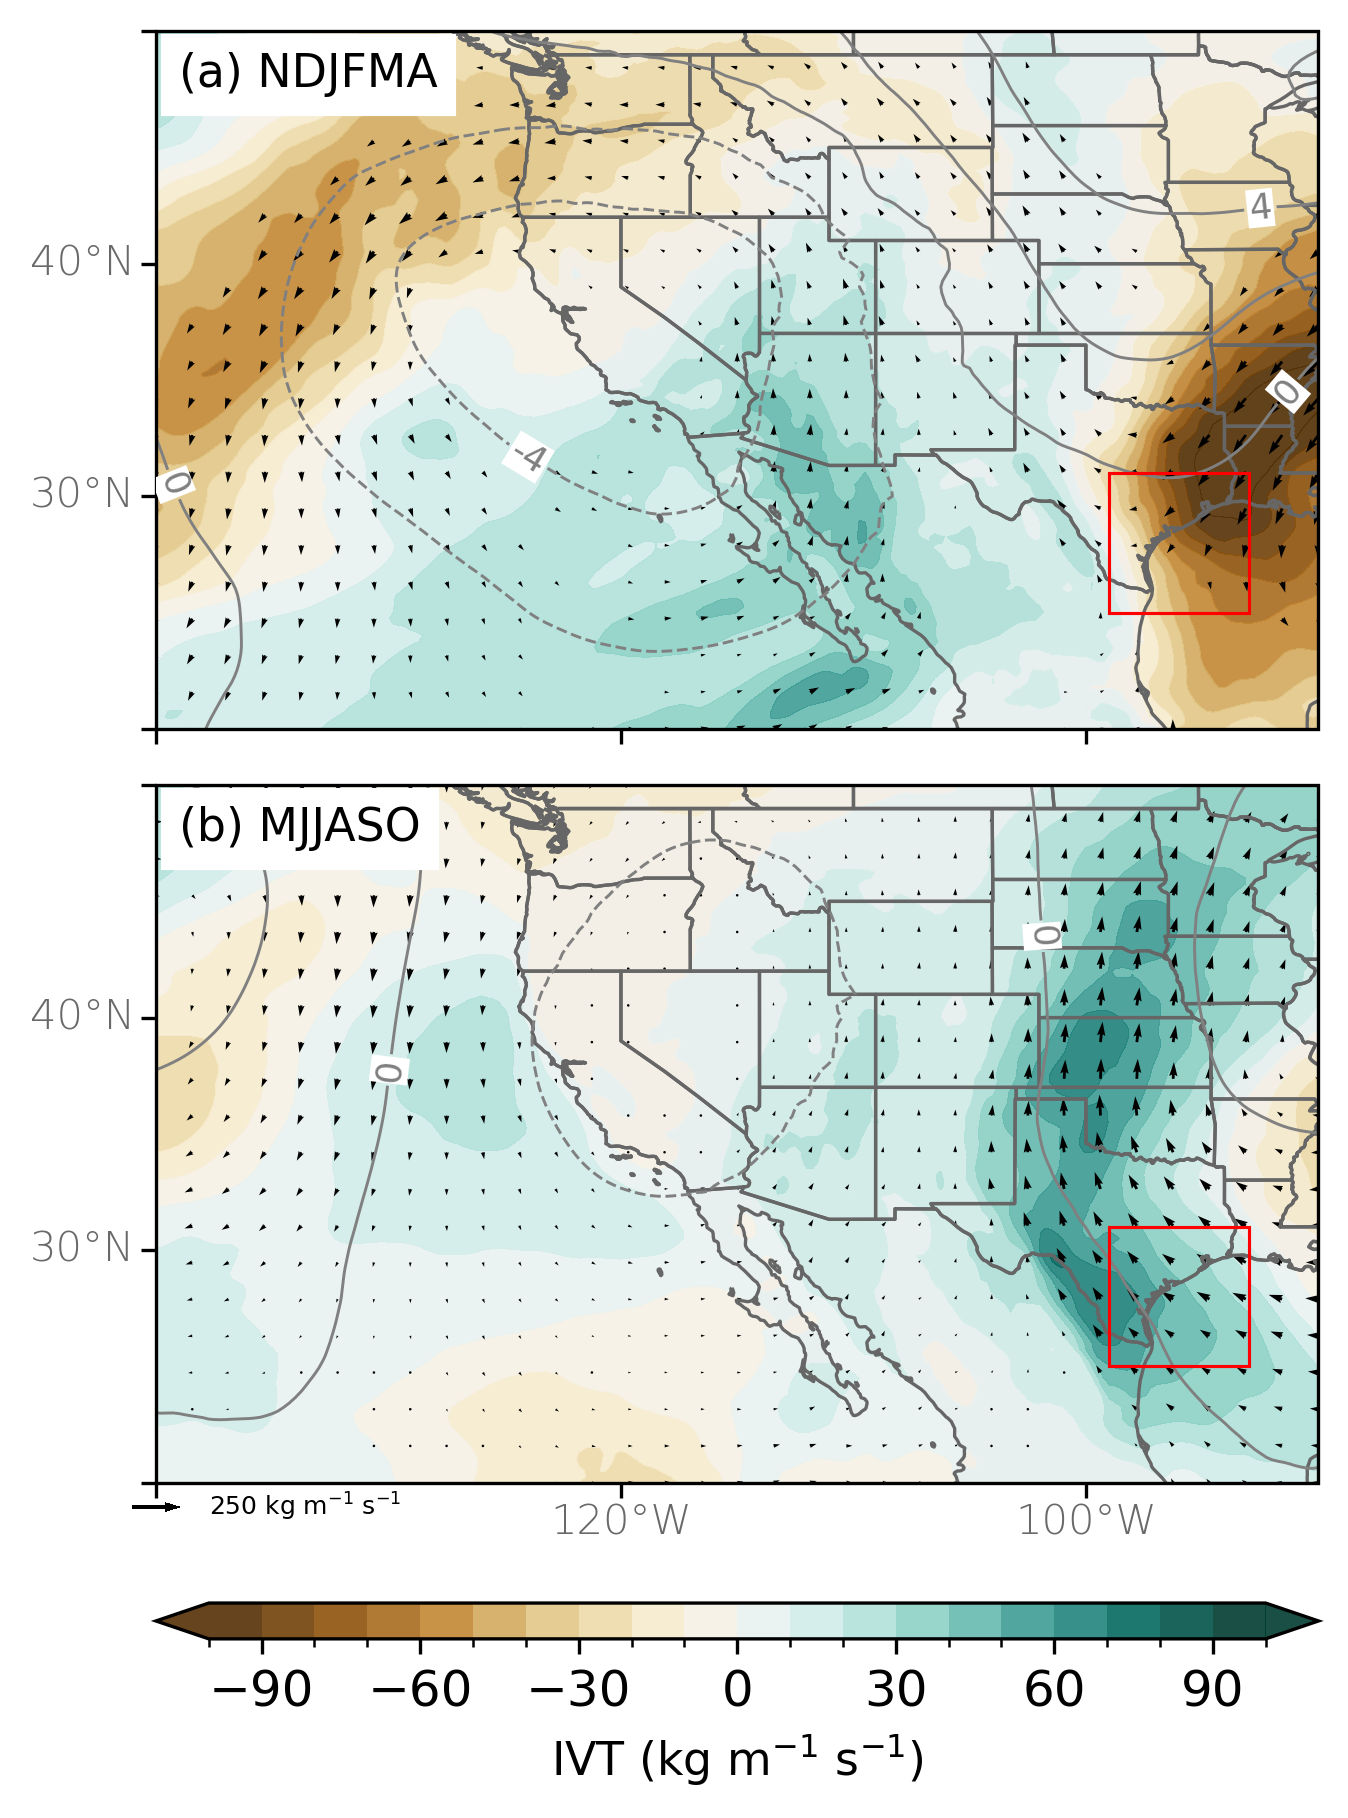

In [8]:
# Create figure
fig = plt.figure(figsize=(5, 7))
fig.dpi = 300
fname = path_to_figs + '{0}_IVT_700z_anom-composite_coolwarm'.format(region)
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 4
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05, 0.05], width_ratios = [1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

#################
### COMPOSITE ###
#################

rowidx = [0, 1, 0, 1]
colidx = [0, 0, 1, 1]
ssn_lst = ['NDJFMA', 'MJJASO']
llats = [True, True]
blons = [False, True]
for i, ssn in enumerate(ssn_lst):
    ds = ds4.sel(ssn=ssn)
    tval = ds3.sel(ssn=ssn)
    ax = fig.add_subplot(gs[rowidx[i], colidx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats[i], right_lats=False, bottom_lons=blons[i])
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    # Contour Filled
    lats = ds.latitude.values
    lons = ds.longitude.values
    ivt = ds.ivt.values
    print(ivt.min(), ivt.max())
    cmap = cm.BrBG
    bnds = np.arange(-100., 110., 10)
    cbarticks = bnds[::2]
    norm = mcolors.BoundaryNorm(bnds, cmap.N)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='both')

    # Wind barbs / vectors 
    uvec_mask = ds.ivtu.where((tval.ivtu == True) | (tval.ivtv == True)).values
    vvec_mask = ds.ivtv.where((tval.ivtu == True) | (tval.ivtv == True)).values

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = ds.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    clevs = np.arange(-20, 22, 2)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
    cl = ax.clabel(cs, clevs[::2], **kw_clabels)
    for txt in cl:
                txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))



    ext3 = d[region]['ext']
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='r',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))
    
    titlestring = '({0}) {1}'.format(letter_lst[i], ssn)
    ax.text(0.02, 0.97, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)


# quiver key
qk = ax.quiverkey(Q, 0.02, -0.035, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})
# Colorbar (single)
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()